In [1]:
from collections import defaultdict, deque
from typing import List
import networkx as nx
import matplotlib.pyplot as plt
import json
import numpy as np
from resources import WorkforceResource

## Task 

In [2]:
# Define Task
class Task:
    def __init__(self, task_id, duration, required_skills, required_equipments):
        self.task_id = task_id
        self.duration = duration
        self.required_skills = required_skills
        self.required_equipments = required_equipments
        self.start_time = None
        self.finish_time = None
        self.color = None
        self.assigned_workforce = None

        if task_id == 'START':
            self.start_time = 0
            self.finish_time = 0

    
    def assign(self, workforce):
        self.assigned_workforce = workforce

    def info(self):
        
        return {
            "task_id": self.task_id,
            "duration": self.duration,
            "required_skills": self.required_skills,
            "required_equipments": self.required_equipments,
            "start_time": self.start_time,
            "finish_time": self.finish_time
        }

# Workforce


In [3]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

class ScheduleGraph(nx.DiGraph):
    def __init__(self, *agrs, **kawgs):
        super(ScheduleGraph, self).__init__(*agrs, **kawgs)


    def load_data(self, schedule_data: dict) -> None:
        for t_name in schedule_data.keys():
            self.add_node(
                schedule_data[t_name]['task_id'],
                duration =  schedule_data[t_name]['duration'], 
                required_skills =  schedule_data[t_name]['required_skills'],
                start_time = 0,
                finish_time = 0
                

                )
            predencors = schedule_data[t_name]['predence']
            
            if predencors != []:
                for predencor in predencors:
                    self.add_edge(predencor, schedule_data[t_name]['task_id'])



    def pertchart(self):
      
        pos = graphviz_layout(self, prog="dot")
        for k,v in pos.items():
            pos[k]=(-v[1],v[0])
        nx.draw_networkx_nodes(self,pos = pos, node_shape = 's', node_size = 200, 
                            node_color = 'none', edgecolors='k')
        nx.draw_networkx_edges(self,pos = pos, 
                            node_shape = 's', width = 1,  node_size = 200)
        nx.draw_networkx_labels(self,pos = pos, font_size = 5)
        plt.savefig("pert_chart.png")
        plt.close()


    def update_schedule(self, start_node: str, contraints: dict = {}):
        
        visited = set()
        queue = deque([start_node])

        if contraints != {}:
            running_times = contraints["running_times"]
            assgined_tasks = contraints["running_times"]
        
        while queue:
            node = queue.popleft()
            if node not in visited:
                predecessors = list(self.predecessors(node))

                if len(list(set(predecessors) & set(visited))) == len(predecessors):
                    visited.add(node)

                if node != start_node and node in visited:
                    early_start_time = max([self.nodes[node]['finish_time'] + 1 for node in predecessors])
                    finish_time =  early_start_time +  self.nodes[node]["duration"]
                    
                    if contraints != {}:
                        if node != 'END':
                            workforce = assgined_tasks[node]
                            running_time = running_times[workforce]
                            # check working time in this task overlap with running time worker's?
                            if len(list(set(range(early_start_time, finish_time + 1)) & set(running_time))) > 0:
                                early_start_time = max(running_time) + 1
                                finish_time =  early_start_time +  self.nodes[node]["duration"]

                            running_times[workforce].extend(range(early_start_time, finish_time + 1))
                    
                    nx.set_node_attributes(self,  {node: {"start_time": early_start_time, "finish_time": early_start_time +  self.nodes[node]["duration"]}})
                    

                for neighbor in list(self.neighbors(node)):
                    if neighbor not in visited:
                        queue.append(neighbor)

    def granttchart(self):
        sorted_nodes = sorted(self.nodes(data=True), key=lambda x: x[1]['start_time'])
        sorted_nodes, _ = zip(*sorted_nodes)
        # Determine the maximum finish time
        max_duration = self.nodes['END']['finish_time']

        # Set up the y-axis range
        plt.ylim(0, len(sorted_nodes))

        # Set up the x-axis range
        plt.xlim(0, max_duration)

        # Draw the nodes as horizontal bars in the Gantt chart
        for i, node in enumerate(sorted_nodes):
            
            start_time = self.nodes[node]['start_time']
            duration = self.nodes[node]['duration']

            plt.barh(i, width=duration, left=start_time, height=0.5, align='center', color="green", edgecolor='black')  # Sử dụng thuộc tính color của task để định nghĩa màu

            plt.text(start_time + duration / 2, i + 0.25, node, ha='center', va='center')

            # Draw the edges in the Gantt chart
            for v in self.neighbors(node):
                u_index = sorted_nodes.index(node)
                v_index = sorted_nodes.index(v)

                start_x = self.nodes[node]['finish_time']
                start_y = u_index
                end_x = self.nodes[v]['start_time']
                end_y = v_index

                mid_x = (start_x + end_x) / 2
                mid_y = (start_y + end_y) / 2

                plt.plot([start_x, mid_x, end_x], [start_y, mid_y, end_y], 'k-', linewidth=1.5)

        # Set y-axis tick labels in the Gantt chart
        plt.yticks(range(len(sorted_nodes)), [node for node in sorted_nodes])

        # Set x-axis label in the Gantt chart
        plt.xlabel('Time')

        # Save the Gantt chart as an image
        plt.grid(axis='x')
        plt.savefig("gantt_chart.png")
        plt.close()

    def visualize(self):
        self.granttchart()
        self.pertchart()

        # Display both the Gantt chart and PERT chart images
        gantt_chart_img = plt.imread("gantt_chart.png")
        pert_chart_img = plt.imread("pert_chart.png")

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Increase the figsize parameter to adjust the size of the displayed images

        axes[0].imshow(gantt_chart_img)
        axes[0].axis('off')
        axes[0].set_title("Gantt Chart")

        axes[1].imshow(pert_chart_img)
        axes[1].axis('off')
        axes[1].set_title("PERT Chart")

        plt.tight_layout()
        plt.show()

In [4]:
contraints = {
    "running_times": {
            "W1": [0],
            "W2": [0],
            "W3": [0],
            "W5": [0],
            "W4": [0],
            "W6": [0],
            "W7": [0],
            "W8": [0],
            "W9": [0],
        
        },

    "assgined_tasks": {
            "T1.1": "W1",
            "T1.2": "W2",
            "T1.3": "W3",
            "T1.4": "W1"  ,
            "T1.5": "W4"  ,
            "T1.6": "W6"  ,
            "T1.7": "W5"  ,
            "T1.8": "W7"   , 
            "T1.9": "W8"  ,   
            "T1.10": "W9"            
        }
}

In [5]:
set(range(3, 10 + 1))

{3, 4, 5, 6, 7, 8, 9, 10}

/var/folders/rn/hgwpqjn159ng5gy4gt_0wff40000gn/T/ipykernel_14521/1505692086.py:29: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(self, prog="dot")


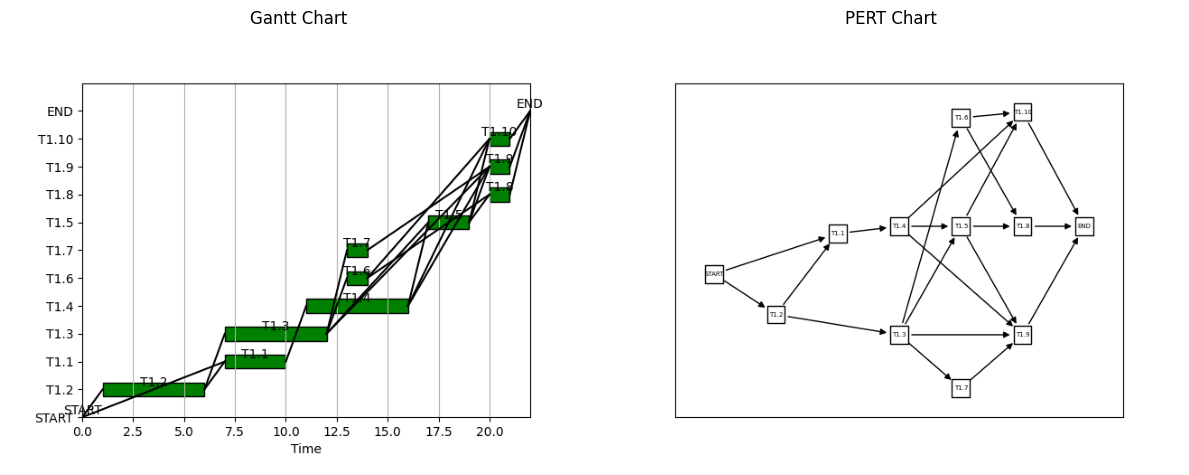

In [6]:
schedule_data_path = 'data/schedule.json'
f = open(schedule_data_path, 'rb')
schedule_data = json.load(f)

schedule_graph = ScheduleGraph(schedule_name = "schedule-demo")
schedule_graph.load_data(schedule_data)

schedule_graph.update_schedule(start_node = "START")
schedule_graph.visualize()

In [7]:
task_schedule = {}
# Create an instance of the Graph class
graph = ScheduleDAG()

for t_name in schedule.keys():

    graph.add_node(
        schedule[t_name]['Tid'],
        duration =  schedule[t_name]['duration'], 
        required_skills =  schedule[t_name]['required_skills'])

    predencors = schedule[t_name]['pred']

   
    if predencors != []:
        for predencor in predencors:
            graph.add_edge(predencor, schedule[t_name]['Tid'])


NameError: name 'ScheduleDAG' is not defined

/var/folders/rn/hgwpqjn159ng5gy4gt_0wff40000gn/T/ipykernel_2005/2737004688.py:11: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(self, prog="dot")


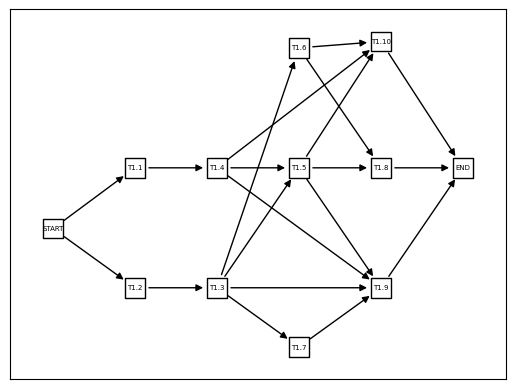

In [ ]:
graph.pertchart()

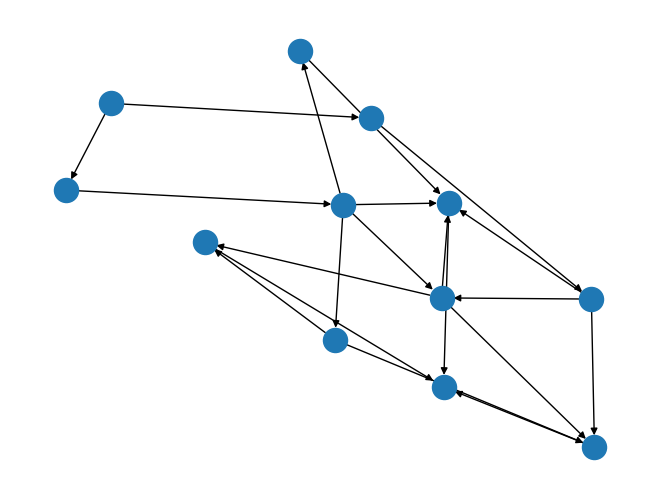

In [ ]:
import matplotlib.pyplot as plt
nx.draw(graph)

plt.show()

In [ ]:
graph.nodes()

NodeView((<__main__.Task object at 0x12861e910>, <__main__.Task object at 0x12855ac70>, <__main__.Task object at 0x12861e730>, <__main__.Task object at 0x12862d550>, <__main__.Task object at 0x12862d1f0>, <__main__.Task object at 0x12862de80>, <__main__.Task object at 0x1285690d0>, <__main__.Task object at 0x1285696a0>, <__main__.Task object at 0x128569eb0>, <__main__.Task object at 0x12864ddc0>, <__main__.Task object at 0x12864d6d0>, <__main__.Task object at 0x12864dee0>))

In [ ]:
import numpy as np


np.random.seed()  # Random seed based on current time
def generate_binary_matrix(workforce, task):
    num_workforce = len(workforce)
    num_tasks = len(task)
    
    workforce_indices = np.random.choice(num_workforce, num_tasks, replace=True)
    matrix = np.zeros((num_workforce, num_tasks), dtype=int)
    
    for i, w in enumerate(workforce_indices):
        matrix[w][i] = 1
    
    return matrix
# Example usage
binary_matrix = generate_binary_matrix(LIST_WORKFORCE, task_schedule.keys())






In [ ]:
binary_matrix

array([[1, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1]])

In [ ]:
for i in range(len(binary_matrix)):
    list_assigns = binary_matrix[i]
    for j in range(len(list_assigns)):
        if list_assigns[j]:
            task_schedule[list(task_schedule.keys())[j]].assign(LIST_WORKFORCE[i])
            LIST_WORKFORCE[i].add_task2workload(task_schedule[list(task_schedule.keys())[j]])

/var/folders/rn/hgwpqjn159ng5gy4gt_0wff40000gn/T/ipykernel_65716/3271895415.py:48: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog='dot')


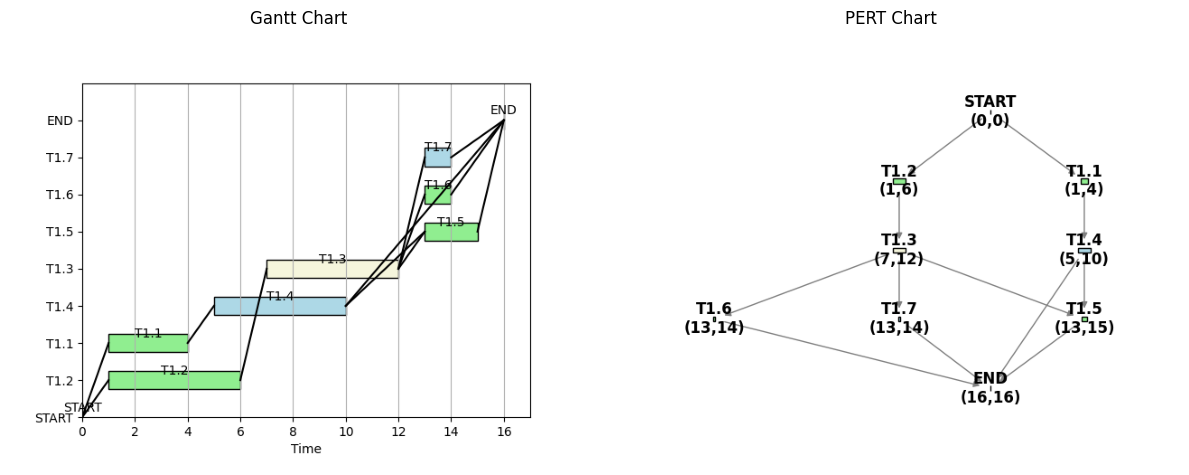

In [ ]:
tasks = bfs(graph, start_node = task_schedule[list(task_schedule.keys())[0]])
graph.visualizeCharts()

/var/folders/rn/hgwpqjn159ng5gy4gt_0wff40000gn/T/ipykernel_65716/3271895415.py:48: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(G, prog='dot')


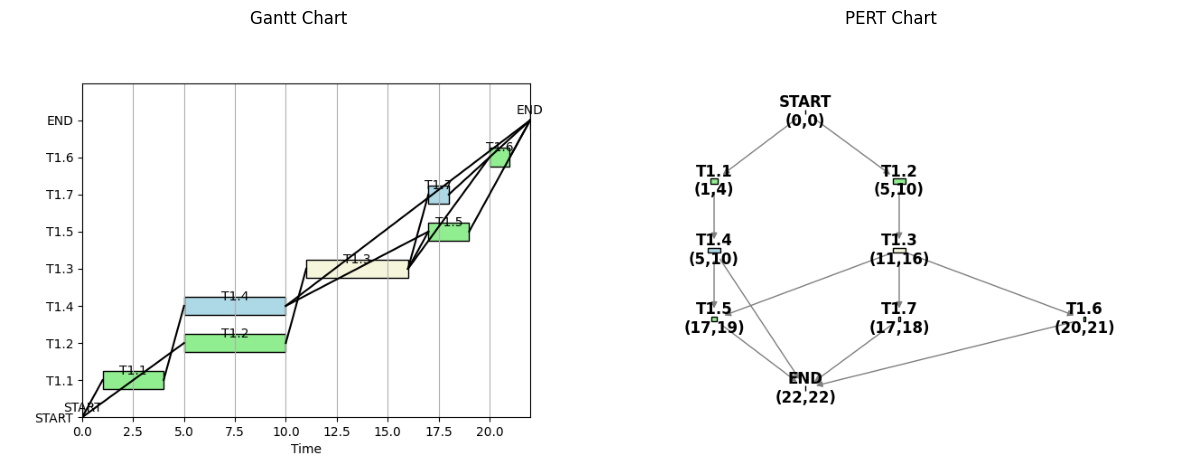

In [ ]:
update_overlap_bfs(graph, start_node = task_schedule[list(task_schedule.keys())[0]])
graph.visualizeCharts()

In [ ]:
graph.nodes[1]

{'time': '5pm'}

LI